In [1]:
import os
import glob
import sys
from pathlib import Path
import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

project_root = Path.cwd().parent  
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
from src.utils.snotel_utils import SNOTEL
from src.utils.utils import data_split

In [2]:
def get_results(nse):
    elevation = []
    nse_list = []
    lat = []
    lon = []
    for key,value in nse.items():
        lat.append(key[0]),lon.append(key[1]),elevation.append(key[2]),nse_list.append(value)
    return lat,lon,elevation,nse_list 

In [3]:
static = xr.open_dataset('/bsuscratch/stanleyakor/uppercolorado/static_inputs/wrfout_d02_2000-04-08_00:00:00').isel(Time = 0)

lat = static.XLAT.values[:,0]
lon = static.XLONG.values[0,:]

In [4]:
path_to_header = '/bsuscratch/stanleyakor/uppercolorado/ml_frameworks/evaluation/DOWNLOAD_SNOTEL/NRCS_SNOTEL_Locations_noAlaska.csv'
path_to_csv = '/bsuscratch/stanleyakor/uppercolorado/ml_frameworks/evaluation/DOWNLOAD_SNOTEL/snotel_data/'
path_to_geog = '/bsuscratch/stanleyakor/uppercolorado/static_inputs/wrfout_d02_2000-04-08_00:00:00'

path_to_emulated_swe = xr.open_dataset('../data/WRF_MODIS_STATIC_v1_PREDITICTION.nc')
start = '2015-10-06'
stop = '2016-09-30'

In [5]:
convlstm =  SNOTEL(var = 'SNOW',\
                 path_to_header = path_to_header,\
                 path_to_csv = path_to_csv ,\
                 path_to_geog = path_to_geog,\
                 path_to_wrf_file = path_to_emulated_swe,\
                 start =  start,\
                 end =  stop)

In [6]:
conlstm_nse = convlstm.read_station_csv()

In [7]:
lat,lon,elevation,convlstm_nse = get_results(conlstm_nse)

In [8]:
wy_2016_true = data_split('2016','2016')

In [9]:
noah =  SNOTEL(var = 'SNOW',\
                 path_to_header = path_to_header,\
                 path_to_csv = path_to_csv ,\
                 path_to_geog = path_to_geog,\
                 path_to_wrf_file = wy_2016_true,\
                 start =  start,\
                 end =  stop)

In [10]:
noah_nse = noah.read_station_csv()

In [11]:
lat,lon,elevation,noah_nse  = get_results(noah_nse)

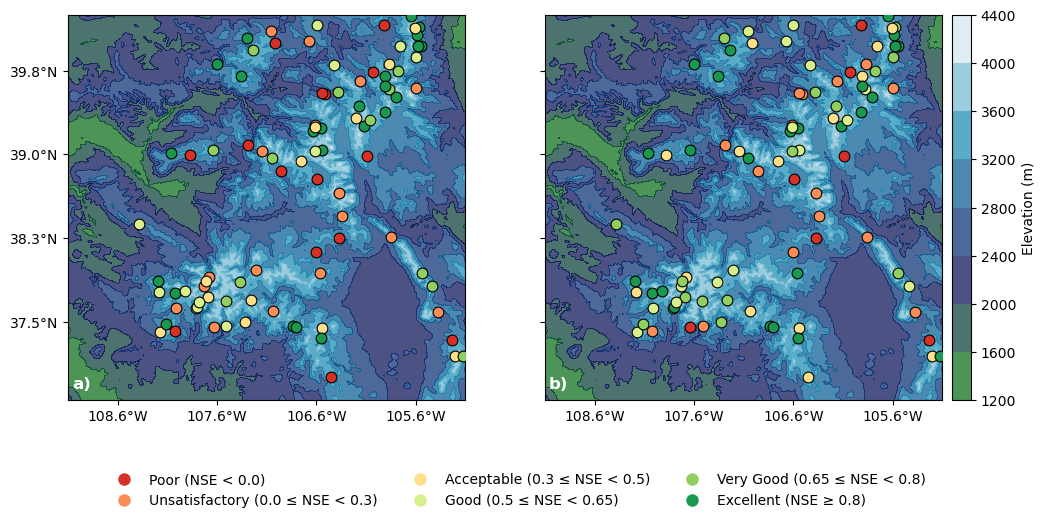

In [12]:
lat,lon = np.array(lat), np.array(lon)
def nse_color(nse):
    if nse < 0.0:
        return "#d73027"  # Red (Poor)
    elif nse < 0.3:
        return "#fc8d59"  # Orange (Unsatisfactory)
    elif nse < 0.5:
        return "#fee08b"  # Yellow (Acceptable)
    elif nse < 0.65:
        return "#d9ef8b"  # Light Green (Good)
    elif nse < 0.8:
        return "#91cf60"  # Green (Very Good)
    else:
        return "#1a9850"  # Dark Green (Excellent)

# Load geographic data
geog = xr.open_dataset(path_to_geog).isel(Time=0)
hgt = geog['HGT']


fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)


contour_levels = 7  

# First subplot - WRF NSE
ax = axes[0]
contour = ax.contourf(geog.XLONG.values, geog.XLAT.values, hgt.values, levels=contour_levels, cmap='ocean', alpha=0.7, zorder=0)
for la, lo, value in zip(lat, lon, noah_nse):
    ax.scatter(lo, la, marker='o', s=60, color=nse_color(value), edgecolor='black', linewidth=0.8, zorder=5)

ax.text(0.01, 0.03, 'a)', transform=ax.transAxes, fontsize=12, color='white', weight='bold')


# Second subplot - Emulator NSE
ax = axes[1]
ax.contourf(geog.XLONG.values, geog.XLAT.values, hgt.values, levels=contour_levels, cmap='ocean', alpha=0.7, zorder=0)
for la, lo, value in zip(lat, lon, convlstm_nse):
    ax.scatter(lo, la, marker='o', s=60, color=nse_color(value), edgecolor='black', linewidth=0.8, zorder=5)

ax.text(0.01, 0.03, 'b)', transform=ax.transAxes, fontsize=12, color='white', weight='bold')

cbar = fig.colorbar(contour, ax=axes.ravel().tolist(), orientation='vertical', label='Elevation (m)', fraction=0.05, pad=0.01)


diff = 0.5  
for i, ax in enumerate(axes.flatten()):
    ax.set_xticks(np.linspace(geog.XLONG.values.min() + diff, geog.XLONG.values.max() - diff, 4))
    ax.set_yticks(np.linspace(lat.min() + diff, lat.max() - diff, 4))

    lon_ticks = ax.get_xticks()
    lat_ticks = ax.get_yticks()
    
    lon_labels = [f'{abs(lon):.1f}°{"W" if lon < 0 else "E"}' for lon in lon_ticks]
    lat_labels = [f'{abs(lat):.1f}°{"S" if lat < 0 else "N"}' for lat in lat_ticks]
    
    ax.set_xticklabels(lon_labels)
    ax.set_yticklabels(lat_labels)

   
nse_legend = [
    ("Poor (NSE < 0.0)", "#d73027"),
    ("Unsatisfactory (0.0 ≤ NSE < 0.3)", "#fc8d59"),
    ("Acceptable (0.3 ≤ NSE < 0.5)", "#fee08b"),
    ("Good (0.5 ≤ NSE < 0.65)", "#d9ef8b"),
    ("Very Good (0.65 ≤ NSE < 0.8)", "#91cf60"),
    ("Excellent (NSE ≥ 0.8)", "#1a9850"),
]

# Create NSE Legend
legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for label, color in nse_legend]
fig.legend(handles=legend_patches, loc='upper center', ncol=3, bbox_to_anchor=(0.5, -0.01), frameon=False)
plt.show()


/tmp/ipykernel_81303/1158929314.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax[0].boxplot(


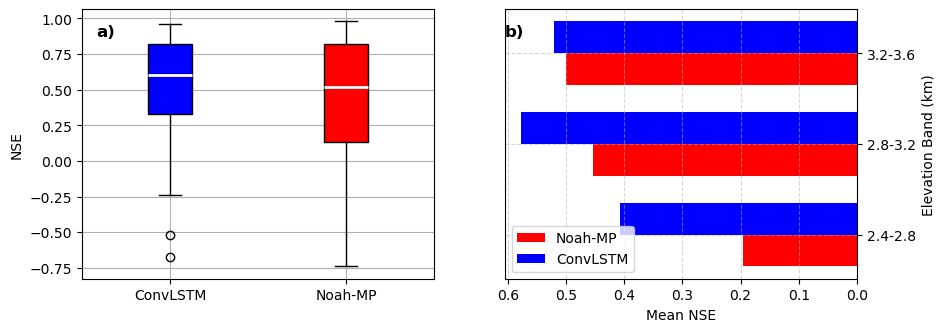

In [13]:


# --- Boxplot comparison ---
fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))

# Create boxplot with matching colors
box = ax[0].boxplot(
    [np.array(convlstm_nse), np.array(noah_nse)],
    labels=['ConvLSTM', 'Noah-MP'],
    patch_artist=True,
    widths=0.25
)

# Set matching colors for boxplot
colors = ['blue', 'red']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Set median color to black
for median in box['medians']:
    median.set(color='white', linewidth=2)

# Axes labels and grid
ax[0].set_ylabel('NSE')
ax[0].grid(True)

# Subplot label
ax[0].text(0.04, 0.9, 'a)', transform=ax[0].transAxes, fontsize=12, color='black', weight='bold')

# --- Elevation-stratified bar chart ---
# Convert elevation from ft to km
elevation_km = (1 / 3.281) * np.array(elevation) / 1000

# Define elevation bins and labels
elev_bins = np.arange(2.4, 3.8, 0.4)
bin_labels = [f"{elev_bins[i]:.1f}-{elev_bins[i+1]:.1f}" for i in range(len(elev_bins) - 1)]

# Assign elevation bins
bin_indices = np.digitize(elevation_km, elev_bins) - 1

# Compute mean NSE per bin
noah_means = []
emulator_means = []
for i in range(len(elev_bins) - 1):
    idx = bin_indices == i
    if np.any(idx):
        noah_means.append(np.mean(np.array(noah_nse)[idx]))
        emulator_means.append(np.mean(np.array(convlstm_nse)[idx]))
    else:
        noah_means.append(np.nan)
        emulator_means.append(np.nan)

# Plot horizontal bar chart
x = np.arange(len(bin_labels))
width = 0.35
ax[1].barh(y=x - width / 2, width=noah_means, height=width, label='Noah-MP', color='red')
ax[1].barh(y=x + width / 2, width=emulator_means, height=width, label='ConvLSTM', color='blue')

# Customize axes
ax[1].set_xlabel('Mean NSE')
ax[1].set_ylabel('Elevation Band (km)')
ax[1].set_yticks(x)
ax[1].set_yticklabels(bin_labels)
# ax[1].invert_yaxis()
ax[1].invert_xaxis()
ax[1].yaxis.set_label_position('right')
ax[1].yaxis.tick_right()

# Grid, legend, subplot label
ax[1].grid(True, linestyle='--', alpha=0.5)
ax[1].legend(loc='lower left')
ax[1].text(-0.0000, 0.9, 'b)', transform=ax[1].transAxes, fontsize=12, color='black', weight='bold')

plt.show()
